In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
# from transformers import BertTokenizer, TFBertModel

In [3]:
from transformers import BertTokenizer, TFBertForMultipleChoice, TFBertForSequenceClassification, TFBertModel

# Data

In [2]:
train_section = pd.read_table("train_dataset.csv", sep='\t', index_col=0)
val_section = pd.read_table("val_dataset.csv", sep='\t', index_col=0)
test_section = pd.read_table("test_dataset.csv", sep='\t', index_col=0)

In [3]:
test_section.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel,TFIDF
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,1,1,a minister who compared gays to pedophiles and...,Biased,0,0,0,0,0,0
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,0,nra ad: are the president's kids more importan...,Neutral,0,0,0,0,1,0
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,1,-1,back to previous page obama hits a wall in ber...,Biased,0,0,0,0,0,0
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,1,"montpelier, idaho (ap) — republicans have made...",Biased,0,0,0,1,0,0
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,1,washington — finally unburdened by worries abo...,Biased,0,0,0,1,0,0


In [4]:
test_labels = [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]

## TF-IDF

In [98]:
!pip install num2words

     |████████████████████████████████| 101 kB 3.5 MB/s ta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=82d8cc5a4fbf069f1ec6d33573e49ae473bdfd20864b9b902fc94c76dc1e9ca7
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [117]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [133]:
# tf-idf processing from https://github.com/williamscott701/Information-Retrieval/blob/master/2.%20TF-IDF%20Ranking%20-%20Cosine%20Similarity%2C%20Matching%20Score/TF-IDF.ipynb

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")


def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text


def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text


def preprocess(data):
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [134]:
train_dataset = list(train_section["text"])
val_dataset = list(val_section["text"])
test_dataset = list(test_section["text"])


In [135]:
def process(dataset):
    processed_text = []
    for i in dataset:
#         processed_text.append(word_tokenize(str(preprocess(i))))
        processed_text.append(str(preprocess(i)))
    return processed_text


In [136]:
train_dataset = process(train_dataset)
val_dataset = process(val_dataset)
test_dataset = process(test_dataset)

In [139]:
# tf-idf from https://stackabuse.com/text-classification-with-python-and-scikit-learn/
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
trainX = vectorizer.fit_transform(train_dataset).toarray()
valX = vectorizer.transform(val_dataset).toarray()
testX = vectorizer.transform(test_dataset).toarray()

In [140]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
trainX = tfidfconverter.fit_transform(trainX).toarray()
valX = tfidfconverter.transform(valX).toarray()
testX = tfidfconverter.transform(testX).toarray()

In [143]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['label']))
val_labels = np.asarray(le.transform(val_section['label']))
test_labels = np.asarray(le.transform(test_section['label']))

In [147]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(trainX, train_labels) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [148]:
y_pred = classifier.predict(testX)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0])

In [149]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# print(confusion_matrix(y_test,y_pred))
print(classification_report(test_labels,y_pred))
print(accuracy_score(test_labels, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.81      0.76        48
           1       0.84      0.74      0.79        62

    accuracy                           0.77       110
   macro avg       0.77      0.78      0.77       110
weighted avg       0.78      0.77      0.77       110

0.7727272727272727


In [ ]:
# print(confusion_matrix(y_test,y_pred))


## Model Results

In [39]:
tfidf_predictions = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [40]:
bert_predictions = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]

In [41]:
# copied from roberta notebook
roberta_predictions = [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]

In [42]:
# frozenroberta_predictions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
#        1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
#        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
#        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
#        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]

In [43]:
# copied from xlnet notebook
xlnet_predictions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]

In [44]:
# frozenxlnet_predictions = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
#        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
#        1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
#        0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
#        1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]

In [45]:
albert_predictions = [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]

In [46]:
test_labels = [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]

In [47]:
predictions = [tfidf_predictions, bert_predictions, roberta_predictions, xlnet_predictions, albert_predictions]
names = ["TFIDF","BERT", "RoBERTa",  "XLNet", "ALBERT"]

# predictions = [bert_predictions, roberta_predictions, frozenroberta_predictions, xlnet_predictions, frozenxlnet_predictions]
# names = ["BERT", "RoBERTa", "RoBERTa (6 layers trained)", "XLNet", "XLNet (6 layers trained)"]

In [48]:
for i in range(len(predictions)):
    predictions[i] = 1-np.array(predictions[i])

In [49]:
test_labels =1-np.array(test_labels)

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [51]:
modelaccuracylist = []
modelnamelist = []
modelprecisionlist = []
modelrecalllist = []
modelf1list = []
mlist = []
print("Metrics for Biased as baseline class (0):")
print()
for i in range(len(predictions)):
    test_classes = predictions[i]
    modelname = names[i]
    modelnamelist.append(modelname)
    print(modelname +" Metrics:")
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(test_labels, test_classes)
    print('Accuracy: %f' % accuracy)
    modelaccuracylist.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(test_labels, test_classes)
    print('Precision: %f' % precision)
    modelprecisionlist.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(test_labels, test_classes)
    print('Recall: %f' % recall)
    modelrecalllist.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_labels, test_classes)
    modelf1list.append(f1)
    print('F1 score: %f' % f1)
    mlist.append([accuracy, precision, recall, f1])
#     print(classification_report(test_labels,test_classes))
    print("")
 

Metrics for Biased as baseline class (0):

TFIDF Metrics:
Accuracy: 0.772727
Precision: 0.709091
Recall: 0.812500
F1 score: 0.757282

BERT Metrics:
Accuracy: 0.745455
Precision: 0.750000
Recall: 0.625000
F1 score: 0.681818

RoBERTa Metrics:
Accuracy: 0.763636
Precision: 0.720000
Recall: 0.750000
F1 score: 0.734694

XLNet Metrics:
Accuracy: 0.809091
Precision: 0.813953
Recall: 0.729167
F1 score: 0.769231

ALBERT Metrics:
Accuracy: 0.654545
Precision: 0.608696
Recall: 0.583333
F1 score: 0.595745



In [31]:
df = pd.DataFrame(columns = modelnamelist)
df.loc['Accuracy'] = modelaccuracylist
df.loc['Precision'] = modelprecisionlist
df.loc['Recall'] = modelrecalllist
df.loc['F1'] = modelf1list
df.head()

,TFIDF,BERT,RoBERTa,XLNet,ALBERT
Accuracy,0.772727,0.745455,0.763636,0.809091,0.654545
Precision,0.709091,0.750000,0.720000,0.813953,0.608696
Recall,0.812500,0.625000,0.750000,0.729167,0.583333
F1,0.757282,0.681818,0.734694,0.769231,0.595745


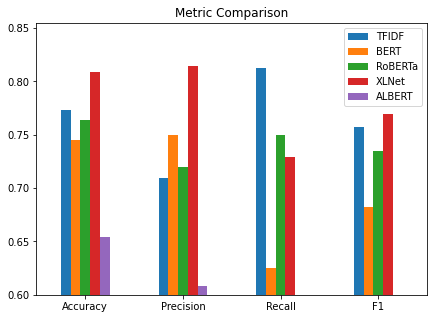

In [33]:
ax = df.plot.bar(rot=0)
ax.set_ylim(ymin=0.6)
ax.figure.set_size_inches(7, 5)
plt.title('Metric Comparison')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('invmodelmetriccomparison.jpg')

In [20]:
bertmodeldata = pd.read_table("bertmodeldata.csv", sep='\t', index_col=0)
robertamodeldata = pd.read_table("robertamodeldata.csv", sep='\t', index_col=0)
# frozenrobertamodeldata = pd.read_table("frozenrobertamodeldata.csv", sep='\t', index_col=0)
xlnetmodeldata = pd.read_table("xlnetmodeldata.csv", sep='\t', index_col=0)
# frozenxlnetmodeldata = pd.read_table("frozenxlnetmodeldata.csv", sep='\t', index_col=0)
albertmodeldata = pd.read_table("albertmodeldata.csv", sep='\t', index_col=0)


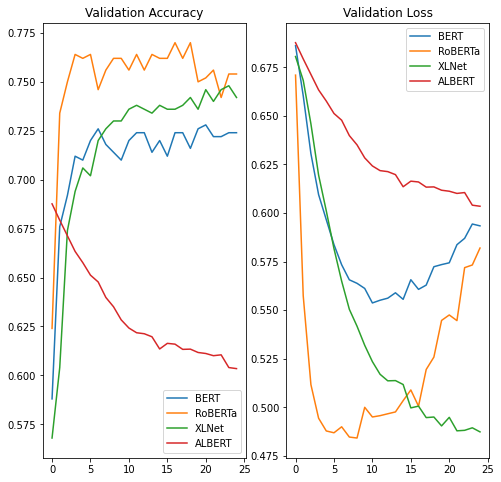

In [21]:
bert_val_acc = bertmodeldata['ValAccuracy']
roberta_val_acc = robertamodeldata['ValAccuracy']
xlnet_val_acc = xlnetmodeldata['ValAccuracy']
albert_val_acc = albertmodeldata['ValAccuracy']

bert_val_loss = bertmodeldata['Val_loss']
roberta_val_loss = robertamodeldata['Val_loss']
# frozenroberta_val_loss = frozenrobertamodeldata['Val_loss']
xlnet_val_loss = xlnetmodeldata['Val_loss']
# frozenxlnet_val_loss = frozenxlnetmodeldata['Val_loss']
albert_val_loss = albertmodeldata['Val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bert_val_acc, label='BERT')
plt.plot(epochs_range, roberta_val_acc, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_acc, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_acc, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bert_val_loss, label='BERT')
plt.plot(epochs_range, roberta_val_loss, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_loss, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_loss, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='upper right')
plt.title('Validation Loss')
# plt.show()
plt.savefig('modeltrainingcomparison.jpg')

In [ ]:
# plot accuracy

In [33]:
def findcommonlabel(predictionlist):
    labellist = []
    for i in range(len(predictionlist[1])):
        allin = True
        labeli = predictionlist[0][i]
        for ii in range(len(predictionlist)):
            if predictionlist[ii][i] !=labeli:
                allin = False
        if allin == True:
            labellist.append(i)
    return labellist

In [34]:
commonpred = findcommonlabel(predictions)
len(commonpred)

64

In [38]:
test_section.reset_index(inplace=True)
test_section.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,0.5,-1.0,Very Liberal,1,1,a minister who compared gays to pedophiles and...,Biased
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,0.0,0.0,Neutral,0,0,nra ad: are the president's kids more importan...,Neutral
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,-1.0,0.0,Conservative,1,-1,back to previous page obama hits a wall in ber...,Biased
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,0.5,-0.5,Liberal,1,1,"montpelier, idaho (ap) — republicans have made...",Biased
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,1.0,0.0,Liberal,1,1,washington — finally unburdened by worries abo...,Biased


In [47]:
commonpreddata = test_section.iloc[commonpred]
commonpreddata.shape

(64, 17)

<AxesSubplot:>

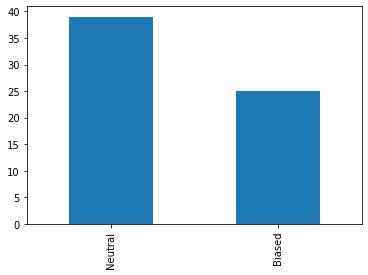

In [40]:
commonpreddata["label"].value_counts().plot.bar()

(array([ 2.,  2.,  7.,  2.,  5.,  1.,  3.,  3.,  4., 35.]),
 array([221. , 258.9, 296.8, 334.7, 372.6, 410.5, 448.4, 486.3, 524.2,
        562.1, 600. ]),
 <BarContainer object of 10 artists>)

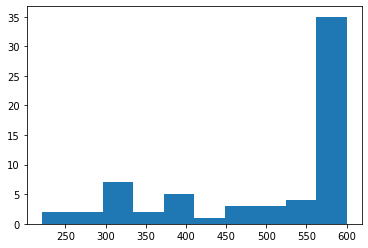

In [49]:
plt.hist(commonpreddata.length)


In [46]:
mixedpreddata = test_section.drop(commonpred, errors='ignore')
mixedpreddata.shape

(46, 17)

<AxesSubplot:>

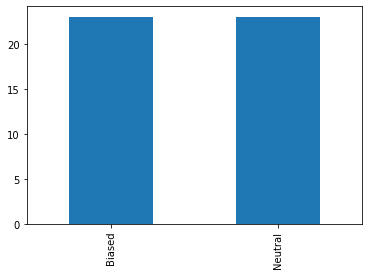

In [48]:
mixedpreddata["label"].value_counts().plot.bar()

(array([ 4.,  1.,  1.,  2.,  5.,  1.,  3.,  1.,  1., 27.]),
 array([235. , 271.5, 308. , 344.5, 381. , 417.5, 454. , 490.5, 527. ,
        563.5, 600. ]),
 <BarContainer object of 10 artists>)

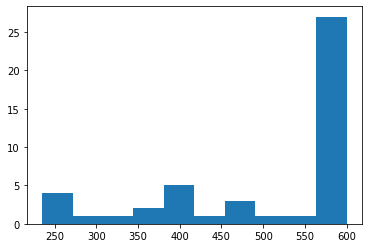

In [50]:
plt.hist(mixedpreddata.length)


In [52]:
for i in range(len(names)):
    test_section[names[i]] = predictions[i]
test_section['encodedlabel'] = test_labels
test_section.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel,TFIDF
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,1,1,a minister who compared gays to pedophiles and...,Biased,1,1,1,1,1,1
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,0,nra ad: are the president's kids more importan...,Neutral,1,1,1,1,0,1
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,1,-1,back to previous page obama hits a wall in ber...,Biased,1,1,1,1,1,1
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,1,"montpelier, idaho (ap) — republicans have made...",Biased,1,1,1,0,1,1
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,1,washington — finally unburdened by worries abo...,Biased,1,1,1,0,1,1


In [35]:
def calculateproportions(df, colname):
    biases = df[df[colname] == 1]
    neutrals = df[df[colname] == 0]
    length = df.shape[0]
    return biases.shape[0]/length, neutrals.shape[0]/length

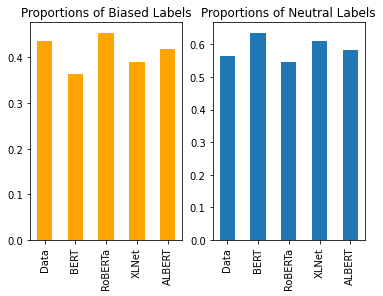

In [57]:
realbiasproportions, realneutralproportions = calculateproportions(test_section, "encodedlabel")
bertbiasproportions, bertneutralproportions = calculateproportions(test_section, "BERT")
robertabiasproportions, robertaneutralproportions = calculateproportions(test_section, "RoBERTa")
xlnetbiasproportions, xlnetneutralproportions = calculateproportions(test_section, "XLNet")
albertbiasproportions, albertneutralproportions = calculateproportions(test_section, "ALBERT")

biasproplist = [realbiasproportions,
               bertbiasproportions,
               robertabiasproportions,
                xlnetbiasproportions,
                albertbiasproportions]
neutralproplist = [realneutralproportions,
               bertneutralproportions,
               robertaneutralproportions,
                xlnetneutralproportions,
                albertneutralproportions]
                
totalnames = ["Data", "BERT","RoBERTa", "XLNet", "ALBERT"]

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)

plt.bar(range(0, len(biasproplist)), biasproplist, color = "orange", width = 0.5, tick_label = totalnames)
plt.ylim(ymin=0)
plt.title('Proportions of Biased Labels')
plt.xticks(rotation=90)
# plt.ylim(ymin=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(0, len(neutralproplist)), neutralproplist, width = 0.5, tick_label = totalnames)
plt.ylim(ymin=0)
plt.title('Proportions of Neutral Labels')
plt.xticks(rotation=90)
# plt.ylim(ymin=0.3)
plt.savefig('modellabelproportioncomparison.jpg')

# plt.bar(range(0, len(biasproplist)), biasproplist, width = 0.25, tick_label = totalnames)
# plt.ylim(ymin=0.3)
# plt.title('Proportions of Biased Labels')



Text(0.5, 1.0, 'Proportions of Neutral Labels')

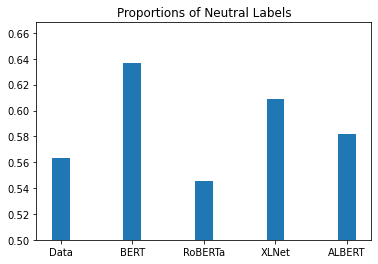

In [37]:
plt.bar(range(0, len(neutralproplist)), neutralproplist, width = 0.25, tick_label = totalnames)
plt.ylim(ymin=0.5)
plt.title('Proportions of Neutral Labels')



In [72]:
test_section[:10]

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biaslabel,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,Very Liberal,1,1,a minister who compared gays to pedophiles and...,Biased,0,0,0,0,0
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,Neutral,0,0,nra ad: are the president's kids more importan...,Neutral,0,0,0,0,1
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,Conservative,1,-1,back to previous page obama hits a wall in ber...,Biased,0,0,0,0,0
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,Liberal,1,1,"montpelier, idaho (ap) — republicans have made...",Biased,0,0,0,1,0
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,Liberal,1,1,washington — finally unburdened by worries abo...,Biased,0,0,0,1,0
5,933,http://www.foxnews.com/politics/2013/07/24/fox...,News,1,Economy,None,Neutral,Neutral,most voters are unhappy with the way things ar...,600,...,Neutral,0,0,most voters are unhappy with the way things ar...,Neutral,1,1,0,1,1
6,9860,http://www.breitbart.com/Big-Government/2013/0...,Opinion,1,Democrat Scandals,Healthcare,SomewhatNegative,SomewhatPositive,rep. raul labrador (r-id) has officially left ...,384,...,Conservative,1,-1,rep. raul labrador (r-id) has officially left ...,Biased,0,1,0,0,0
7,3620,http://www.breitbart.com/Big-Government/2013/0...,News,0,Republican Scandals,None,Neutral,Negative,“karl rove is bad news for the republican part...,387,...,Liberal,1,1,“karl rove is bad news for the republican part...,Biased,0,0,0,0,0
8,3959,http://www.breitbart.com/Big-Government/2013/1...,Opinion,0,None,None,Negative,Neutral,"just in time for christmas, president obama si...",304,...,Conservative,1,-1,"just in time for christmas, president obama si...",Biased,0,0,0,0,0
9,1645,http://www.breitbart.com/Big-Journalism/2013/1...,News,1,International News,National Security,Neutral,Neutral,"on sunday evening, cbs news’ 60 minutes featur...",561,...,Neutral,0,0,"on sunday evening, cbs news’ 60 minutes featur...",Neutral,0,0,0,0,1


In [77]:
realneutraldata = test_section[(test_section["encodedlabel"] ==1)
            & (test_section["BERT"]== 0)
             & (test_section["RoBERTa"]== 0)
             & (test_section["XLNet"]== 0)
             & (test_section["ALBERT"]== 0)]
realneutraldata

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biaslabel,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,Neutral,0,0,nra ad: are the president's kids more importan...,Neutral,0,0,0,0,1
9,1645,http://www.breitbart.com/Big-Journalism/2013/1...,News,1,International News,National Security,Neutral,Neutral,"on sunday evening, cbs news’ 60 minutes featur...",561,...,Neutral,0,0,"on sunday evening, cbs news’ 60 minutes featur...",Neutral,0,0,0,0,1
93,2758,http://www.dailykos.com/story/2013/02/24/11894...,News,1,Economy,Gun Rights Regulation,Neutral,Neutral,"in 2012, the state legislature narrowly passed...",600,...,Neutral,0,0,"in 2012, the state legislature narrowly passed...",Neutral,0,0,0,0,1
106,3941,http://politicalticker.blogs.cnn.com/2013/10/0...,News,1,Healthcare,None,Neutral,Neutral,7 years ago washington ( SOURCE ) – sen. ted c...,600,...,Neutral,0,0,7 years ago washington ( SOURCE ) – sen. ted c...,Neutral,0,0,0,0,1


In [60]:
test_section.iloc[106].article

'7 years ago washington ( SOURCE ) – sen. ted cruz got a lot of pushback from republican colleagues during a closed-door meeting questioning his relentless effort to tie government funding to derailing obamacare. "cruz was completely unapologetic about the ads that he is featured in on the senate conservatives fund website that attack other republicans. he sees himself as the only truly pure republican. his colleagues are furious. he has no successful strategy but has managed to generate grass roots support for his position," one senior republican source at wednesday\'s meeting told SOURCE chief political analyst gloria borger. cruz has urged republicans in the house to stand firm and continue pushing any plan to fund the government to proposals aimed at curtailing the affordable care act. this summer, he appeared in ads produced by the senate conservatives fund urging republicans to push congress to defund obamacare. this strategy has upset senate republicans and some house gop member

In [59]:
test_section.iloc[1].article

"nra ad: are the president's kids more important than yours? then why is he skeptical about putting armed security in our schools when his kids are protected by armed guards at their school? i swear to you, if i didn't know any better, and i'm not a big conspiracy guy, after seeing that ad, i would think the nra is either an elaborate avant-garde joaquin phoenix-style joke, or a false flag operation run by michael moore in an attempt to discredit responsible gun owners. but anyway, your response, mr. president. barack obama (1 16 2013): i believe the second amendment guarantees an individual right to bear arms. ... i also believe most gun owners agree that we can respect the second amendment while keeping an irresponsible law-breaking few from inflicting harm on a massive scale. but anyhow, at that conference today at the white house, the president unveiled legislative proposals and 23 executive actions to begin to address gun violence, including recommendations to limit magazine size,

In [90]:
xlnetbiasvsneutral = test_section[(test_section["encodedlabel"] ==1)
             & (test_section["XLNet"]== 0)]
xlnetbiasvsneutral

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biaslabel,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,Neutral,0,0,nra ad: are the president's kids more importan...,Neutral,0,0,0,0,1
5,933,http://www.foxnews.com/politics/2013/07/24/fox...,News,1,Economy,None,Neutral,Neutral,most voters are unhappy with the way things ar...,600,...,Neutral,0,0,most voters are unhappy with the way things ar...,Neutral,1,1,0,1,1
9,1645,http://www.breitbart.com/Big-Journalism/2013/1...,News,1,International News,National Security,Neutral,Neutral,"on sunday evening, cbs news’ 60 minutes featur...",561,...,Neutral,0,0,"on sunday evening, cbs news’ 60 minutes featur...",Neutral,0,0,0,0,1
55,1542,http://money.cnn.com/2013/11/07/news/economy/o...,News,0,Healthcare,None,Neutral,Neutral,there's a lot to recommend marriage. but if yo...,518,...,Neutral,0,0,there's a lot to recommend marriage. but if yo...,Neutral,0,0,0,1,1
69,1191,http://www.huffingtonpost.com/2013/06/30/rache...,News,1,Gay Rights,None,Neutral,Neutral,rachel maddow sparred with conservatives over ...,242,...,Neutral,0,0,rachel maddow sparred with conservatives over ...,Neutral,0,0,0,1,1
90,756,http://www.foxnews.com/politics/2013/06/25/sup...,News,1,Elections,None,Neutral,Neutral,a landmark supreme court ruling that struck do...,600,...,Neutral,0,0,a landmark supreme court ruling that struck do...,Neutral,0,1,0,1,1
93,2758,http://www.dailykos.com/story/2013/02/24/11894...,News,1,Economy,Gun Rights Regulation,Neutral,Neutral,"in 2012, the state legislature narrowly passed...",600,...,Neutral,0,0,"in 2012, the state legislature narrowly passed...",Neutral,0,0,0,0,1
106,3941,http://politicalticker.blogs.cnn.com/2013/10/0...,News,1,Healthcare,None,Neutral,Neutral,7 years ago washington ( SOURCE ) – sen. ted c...,600,...,Neutral,0,0,7 years ago washington ( SOURCE ) – sen. ted c...,Neutral,0,0,0,0,1


In [93]:
realbiasdata = test_section[(test_section["encodedlabel"] ==0)
            & (test_section["BERT"]== 1)
             & (test_section["RoBERTa"]== 1)
             & (test_section["XLNet"]== 1)]
realbiasdata

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biaslabel,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel
21,7533,http://www.foxnews.com/politics/2013/11/29/law...,News,0,Gun Rights Regulation,Gun Related Crimes,SomewhatPositive,SomewhatNegative,congressional lawmakers will face a critical d...,497,...,Liberal,1,1,congressional lawmakers will face a critical d...,Biased,1,1,1,1,0
24,4589,http://news.yahoo.com/treasurys-lew-congress-n...,Opinion,1,Economy,None,SomewhatNegative,SomewhatPositive,washington (ap) -- congress needs to raise the...,600,...,Conservative,1,-1,washington (ap) -- congress needs to raise the...,Biased,1,1,1,1,0
25,222,http://www.nytimes.com/2013/10/21/us/insurance...,News,0,Healthcare,None,SomewhatNegative,SomewhatPositive,federal contractors have identified most of th...,221,...,Conservative,1,-1,federal contractors have identified most of th...,Biased,1,1,1,1,0
51,4044,http://www.huffingtonpost.com/2013/11/14/nancy...,News,0,None,None,SomewhatPositive,Negative,washington -- following reports that house spe...,313,...,Very Liberal,1,1,washington -- following reports that house spe...,Biased,1,1,1,1,0
74,4171,http://news.yahoo.com/despite-outcry-stand-gro...,Opinion,1,Gun Related Crimes,Gun Rights Regulation,SomewhatPositive,Negative,miami (ap) — despite an outcry from civil righ...,600,...,Very Liberal,1,1,miami (ap) — despite an outcry from civil righ...,Biased,1,1,1,1,0
103,8088,http://www.usatoday.com/story/theoval/2013/06/...,News,0,Gun Rights Regulation,None,SomewhatPositive,SomewhatNegative,david jackson SOURCE the white house says ...,333,...,Liberal,1,1,david jackson SOURCE the white house says ...,Biased,1,1,1,1,0


In [232]:
test_section[(test_section["encodedlabel"] ==0)
            & (test_section["XLNet"]== 1)]

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biaslabel,isbiased,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel
11,8703,http://www.washingtonpost.com/business/economy...,News,0,Economy,None,SomewhatPositive,SomewhatNegative,congress approved a plan to end washington’s l...,600,...,Liberal,1,1,congress approved a plan to end washington’s l...,Biased,1,0,1,1,0
16,9741,http://www.nytimes.com/2013/09/30/opinion/birt...,Opinion,1,Healthcare,None,SomewhatPositive,SomewhatNegative,the obama administration’s rule requiring empl...,301,...,Liberal,1,1,the obama administration’s rule requiring empl...,Biased,0,0,1,0,0
18,1867,http://www.nytimes.com/2013/08/19/opinion/kell...,Opinion,0,Education,Republican Scandals,Neutral,Negative,so let’s take a look at this fiendish federal ...,401,...,Liberal,1,1,so let’s take a look at this fiendish federal ...,Biased,0,0,1,0,0
21,7533,http://www.foxnews.com/politics/2013/11/29/law...,News,0,Gun Rights Regulation,Gun Related Crimes,SomewhatPositive,SomewhatNegative,congressional lawmakers will face a critical d...,497,...,Liberal,1,1,congressional lawmakers will face a critical d...,Biased,1,1,1,1,0
24,4589,http://news.yahoo.com/treasurys-lew-congress-n...,Opinion,1,Economy,None,SomewhatNegative,SomewhatPositive,washington (ap) -- congress needs to raise the...,600,...,Conservative,1,-1,washington (ap) -- congress needs to raise the...,Biased,1,1,1,1,0
25,222,http://www.nytimes.com/2013/10/21/us/insurance...,News,0,Healthcare,None,SomewhatNegative,SomewhatPositive,federal contractors have identified most of th...,221,...,Conservative,1,-1,federal contractors have identified most of th...,Biased,1,1,1,1,0
50,1419,http://www.huffingtonpost.com/2013/12/26/chris...,News,0,Republican Scandals,None,Neutral,Negative,washington -- new documents reveal that a high...,600,...,Liberal,1,1,washington -- new documents reveal that a high...,Biased,1,0,1,1,0
51,4044,http://www.huffingtonpost.com/2013/11/14/nancy...,News,0,None,None,SomewhatPositive,Negative,washington -- following reports that house spe...,313,...,Very Liberal,1,1,washington -- following reports that house spe...,Biased,1,1,1,1,0
63,4530,http://www.foxnews.com/politics/2013/05/13/ben...,Opinion,1,Democrat Scandals,None,Negative,SomewhatPositive,the resurgent controversy over the obama admin...,600,...,Very Conservative,1,-1,the resurgent controversy over the obama admin...,Biased,0,0,1,0,0
74,4171,http://news.yahoo.com/despite-outcry-stand-gro...,Opinion,1,Gun Related Crimes,Gun Rights Regulation,SomewhatPositive,Negative,miami (ap) — despite an outcry from civil righ...,600,...,Very Liberal,1,1,miami (ap) — despite an outcry from civil righ...,Biased,1,1,1,1,0


In [238]:
test_section.to_csv("test_dataset.csv", sep='\t')

In [ ]:
breitbartdata = test_section[test_section["url"].str.contains('breitbart.com')]
